In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tempfile

In [2]:
df = pd.read_csv("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data\\data with rsi.csv")
print(df)

      Unnamed: 0.1  Unnamed: 0              date     open     high      low  \
0                0           0    4/22/2025 3:00  3471.10  3475.10  3466.80   
1                1           1    4/22/2025 4:00  3472.57  3494.08  3472.28   
2                2           2    4/22/2025 5:00  3487.55  3487.94  3479.20   
3                3           3    4/22/2025 6:00  3484.95  3495.01  3474.14   
4                4           4    4/22/2025 7:00  3492.59  3499.45  3477.36   
...            ...         ...               ...      ...      ...      ...   
2937          2937        2937  10/10/2025 11:00  3995.56  3999.84  3990.61   
2938          2938        2938  10/10/2025 12:00  3993.50  3999.70  3983.56   
2939          2939        2939  10/10/2025 13:00  3987.35  3993.31  3980.01   
2940          2940        2940  10/10/2025 14:00  3985.33  3997.99  3975.26   
2941          2941        2941  10/10/2025 15:00  3978.64  3993.93  3970.39   

        close  volume  past_ret_1h  past_ret_2h  pa

In [3]:
df["target"] = df["forward regime"].map({
    "range": 0,
    "upward": 1,
    "downward": 2
})

In [4]:
features = ["open", "1 percent prediction", "past_ret_16h", "RSI_16"]

X = df[features]
y = df["target"]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
# class weights - manual
#  important

w_range    = 1.5
w_up       = 10
w_down     = 12

class_weights = [w_range, w_up, w_down]
print("Class weights:", class_weights)

Class weights: [1.5, 10, 12]


In [22]:
# auto class weights

class_counts = y_train.value_counts()
total = len(y_train)

class_weights = {
    c: total / class_counts[c]
    for c in class_counts.index
}

print(class_weights)

{0: 1.511747430249633, 1: 5.33419689119171, 2: 6.620578778135048}


In [23]:
import os
os.getcwd()

'C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data'

In [24]:
os.chdir("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data")

In [25]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function="MultiClass",
    depth=8,
    learning_rate=0.03,
    iterations=5000,             # large, but early stopping will stop when needed
    random_seed=42,
    class_weights=class_weights, # important for imbalance
    eval_metric="TotalF1",       # better than accuracy for imbalanced 3-class problems
    od_type="Iter",
    od_wait=100,                 # stop early if no improvement
    task_type="GPU",             # auto falls back to CPU if no GPU
    verbose=200
)

model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)


0:	learn: 0.4871488	test: 0.3870740	best: 0.3870740 (0)	total: 9.8ms	remaining: 49s
200:	learn: 0.7441481	test: 0.4901883	best: 0.4922613 (198)	total: 1.97s	remaining: 47.1s
400:	learn: 0.8259704	test: 0.5102213	best: 0.5133718 (396)	total: 3.75s	remaining: 43s
bestTest = 0.5133718141
bestIteration = 396
Shrink model to first 397 iterations.


In [26]:
y_pred = model.predict(X_valid)
y_pred = y_pred.astype(int).flatten()

print("\nCLASSIFICATION REPORT")
print(classification_report(y_valid, y_pred))

print("\nCONFUSION MATRIX")
print(confusion_matrix(y_valid, y_pred))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       584
           1       0.34      0.45      0.39       165
           2       0.33      0.48      0.39       134

    accuracy                           0.56       883
   macro avg       0.48      0.51      0.48       883
weighted avg       0.62      0.56      0.58       883


CONFUSION MATRIX
[[356 126 102]
 [ 61  75  29]
 [ 49  21  64]]


In [27]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

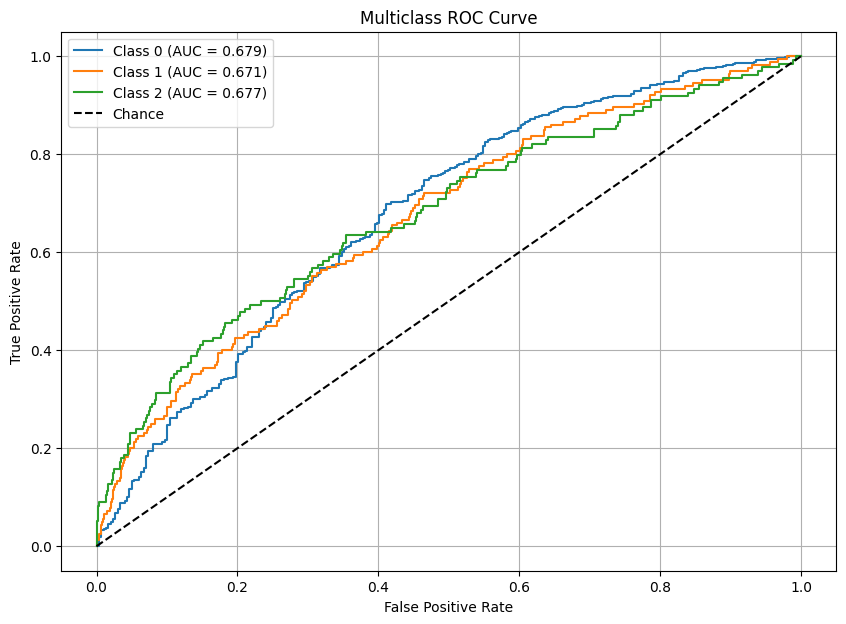

In [28]:
probs = model.predict_proba(X_valid)

# Binarize labels
classes = np.unique(y_valid)
y_bin = label_binarize(y_valid, classes=classes)

plt.figure(figsize=(10, 7))

for idx, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, idx], probs[:, idx])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {c} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


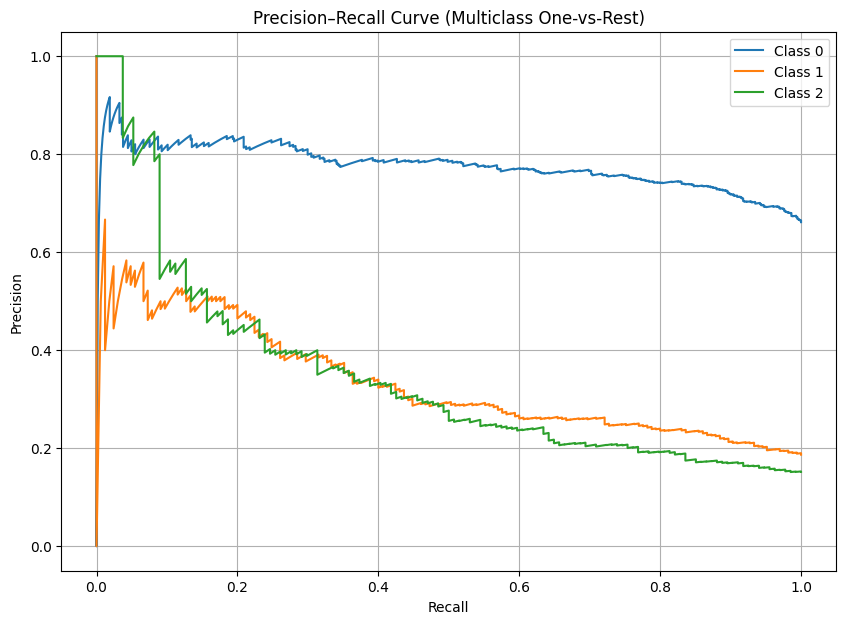

In [29]:
plt.figure(figsize=(10, 7))

for idx, c in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, idx], probs[:, idx])
    plt.plot(recall, precision, label=f"Class {c}")

plt.title("Precision–Recall Curve (Multiclass One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

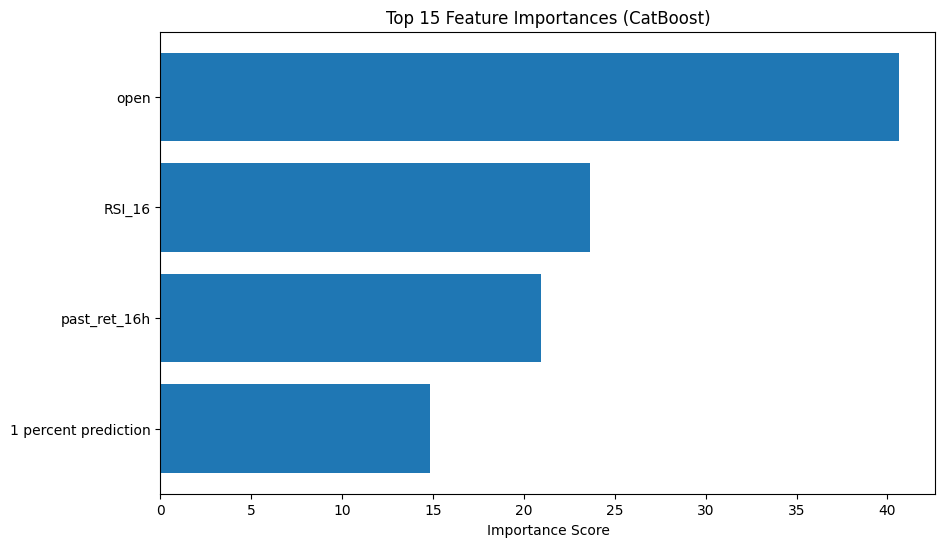

In [30]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_names = feature_names[sorted_idx]
sorted_scores = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:15], sorted_scores[:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (CatBoost)")
plt.xlabel("Importance Score")
plt.show()
